# Foreign Gifts and Contracts to Columbia University

_Source: [Foreign Gifts and Contracts Report](https://catalog.data.gov/dataset/foreign-gifts-and-contracts-report-2011)_

In [40]:
%%capture

from collections import defaultdict
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime

matplotlib.rcParams.update({'font.size': 14})
plt.tight_layout()

Let's read in the data. We filter out any gifts that weren't given to Columbia University.

In [3]:
df = pd.read_excel('../data/ForeignGifts.xlsx')
df.columns = df.iloc[0]
df.set_index('ID')
df = df.iloc[1:]
df = df[df['Institution Name'] == 'Columbia University in the City of New York']
df['Foreign Gift Amount'] = pd.to_numeric(df['Foreign Gift Amount'])
df['Foreign Gift Received Date'] = pd.to_datetime(df['Foreign Gift Received Date'])

COUNTRIES = df['Country of Giftor'].unique()

# Totals

Let's take a look at the total donations from each country to Columbia. We sum all donations for each country and sort them into monetary gifts and contracts (the only two gift types in the database).

In [4]:
# Returns two dictionaries: monetary gifts and contracts.
# Key: Country name; value: total gift amount
def getGifts():
    monetaryGifts = defaultdict(int)
    contracts = defaultdict(int)

    for _, gift in df.iterrows():
        country = gift['Country of Giftor']
        amount = gift['Foreign Gift Amount']
        if gift['Gift Type'] == 'Monetary Gift':
            monetaryGifts[ country ] += amount
        else:
            contracts[ country ] += amount
    return [monetaryGifts, contracts]

def getGiftsByCountry(countries=COUNTRIES, doSort=False):
    filterByCountry = lambda gifts: [gifts[c] for c in countries]
    
    [monetaryGifts, contracts] = [
        filterByCountry(giftList) for giftList in getGifts()
    ]
    
    def countrySum(tup):
        (monetary, contract, country) = tup
        return monetary + contract
    
    output = [monetaryGifts, contracts, countries]
    if doSort:
        output = zip(*sorted(zip(*output), key=countrySum))
    return output

In [5]:
def drawGiftsByCountry():    
    [monetaryGifts, contracts, countries] = getGiftsByCountry(doSort=True)

    fig, ax = plt.subplots(figsize=(13,13))
    indices = np.arange(len(countries))

    width = 1
    p1 = ax.bar(indices, monetaryGifts, width, color='#d62728', edgecolor='black')
    p2 = ax.bar(indices, contracts, width, bottom=monetaryGifts, edgecolor='black')

    plt.legend((p1[0], p2[0]), ('Monetary Gift', 'Contract'))

    plt.xticks(indices, countries)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set(xlabel='Country of Giftor', ylabel='Foreign Gift Amount',
           title='Foreign Gifts to Columbia University by Country and Gift Type')
    ax.grid()

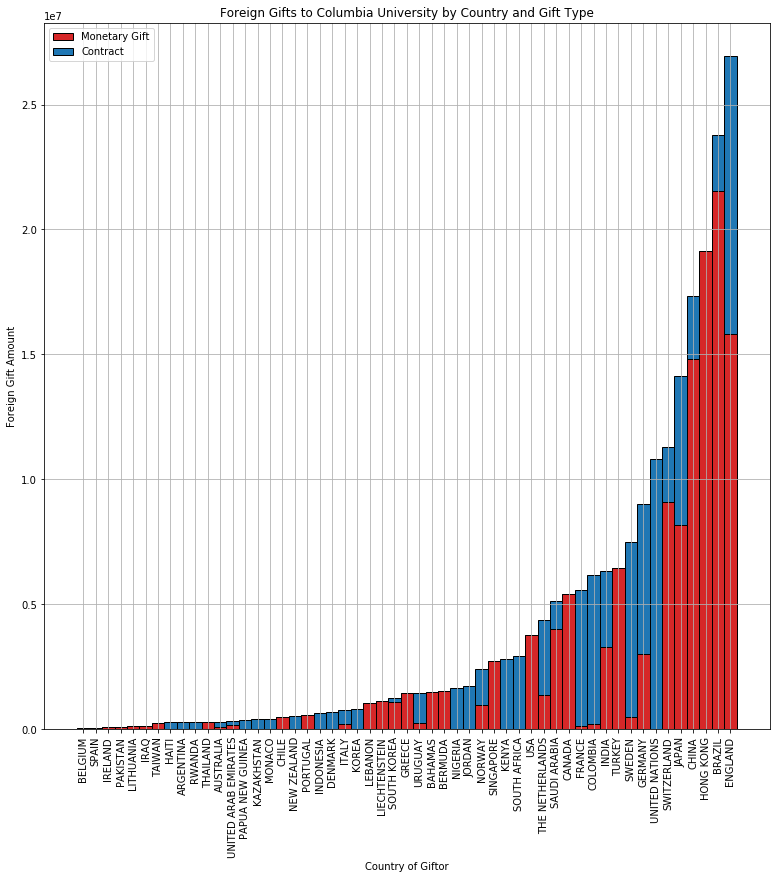

In [7]:
drawGiftsByCountry()

# Time Series

Let's now take a look at the gifts over time, first from the top 10 giftor countries.

In [28]:
def getGiftsWithDate(country):
    dates = []
    amounts = []
    for _, gift in df[df['Country of Giftor'] == country].iterrows():
        dates.append(gift['Foreign Gift Received Date'])
        amounts.append(gift['Foreign Gift Amount'])
    return [dates, amounts]

In [53]:
def lineGifts(plot, country):
    [dates, amounts] = getGiftsWithDate(country)
    plot.plot(dates, amounts, marker='.', label=country)
    plot.set_title(country)
    plot.set(xlabel='Date', ylabel='Foreign Gift Amount')
    plot.legend()
    plot.grid()
    plot.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
    )
    datemin = datetime.date(2013, 1, 1)
    datemax = datetime.date(2019, 1, 1)
    plot.set_xlim(datemin, datemax)
    
def getTopCountries(limit=10):
    [_, _, countries] = getGiftsByCountry(doSort=True)
    return countries[-1:-limit:-1]

def drawCountry(country):    
    fig, ax = plt.subplots(figsize=(10, 10))
    lineGifts(ax, country)

In [54]:
top10 = getTopCountries()
# ('ENGLAND', 'BRAZIL', 'HONG KONG', 'CHINA', 'JAPAN', 'SWITZERLAND', 'UNITED NATIONS', 'GERMANY', 'SWEDEN')

Let's take a look at these 10 countries.

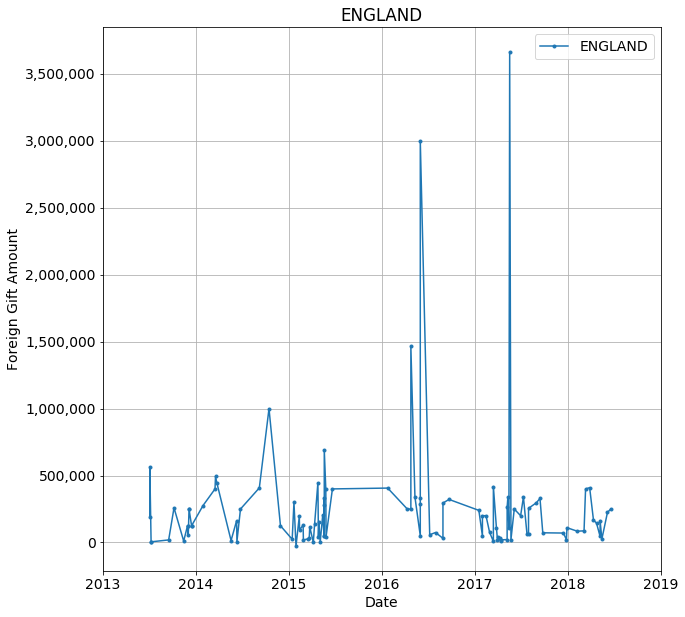

In [61]:
drawCountry('ENGLAND')

# England

UNILEVER: Industry affiliate with DSI

CENTRE FOR ECONOMIC POLICY RESEARCH: Not found. Could just be research contracts/etc.

Afren PLC: In May 2013, a [SIPA team](http://admissionsblog.sipa.columbia.edu/tag/afren-plc/)'s capstone project was a case study with Afren. _So they were paid?_

The Gatsby Charitable Foundation: gives grants to CU students to support non-curricular arts projects

# Brazil

Many Brazillian gifts are monetary gifts from the Lemann Foundation, which is run by Jorge Lemann, Brazil's richest man.